### Inside the heads of Putnuts
#### An analysis of the Only Murders in the Building TV show subreddit

Milindi Kodikara

#### Step 1 : : Set up

In [ ]:
# Installs dependencies
import sys
!{sys.executable} -m pip install -r requirements.txt

In [1]:
from client import client
import helper
import visualiser

import string

import nltk 
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('vader_lexicon')

from datetime import datetime
import calendar
import pandas as pd
import pyLDAvis.lda_model

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/milindi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
subreddit_name = 'OnlyMurdersHulu'

In [3]:
reddit_client = client()

In [4]:
print('Username :: ', reddit_client.user.me())

Username ::  Yet_Another_Me_00


In [5]:
subreddit = reddit_client.subreddit(subreddit_name)

print('Subreddit :: ', subreddit)

Subreddit ::  OnlyMurdersHulu


#### Step 2 : : Data Collection

In [6]:
all_new_posts = [*subreddit.new(limit=None)] 

new_season_announcement_date = datetime(2023, 10, 4, 0, 0, 0)
week_after_season_premier = datetime(2024, 9, 3, 23, 59, 59)

timestamp_new_season_announcement_date = calendar.timegm(new_season_announcement_date.utctimetuple())
timestamp_week_after_season_premier = calendar.timegm(week_after_season_premier.utctimetuple())

posts = [post for post in all_new_posts if timestamp_new_season_announcement_date <= post.created_utc <= timestamp_week_after_season_premier]

print('New season announcement date: ', new_season_announcement_date.strftime("%d/%m/%Y"))
print('New season announcement date timestamp: ', timestamp_new_season_announcement_date)

print('Week after season premier: ', week_after_season_premier.strftime("%d/%m/%Y"))
print('Week after season premier timestamp: ', timestamp_week_after_season_premier)

print(f'New posts: {len(all_new_posts)}\nNew posts from the new season announcement leading up to season premier: {len(posts)}')

New season announcement date:  04/10/2023
New season announcement date timestamp:  1696377600
Week after season premier:  03/09/2024
Week after season premier timestamp:  1725407999
New posts: 988
New posts from the new season announcement leading up to season premier: 915


In [7]:
# Colour palette 
oliver = '#275c4d'
mabel = '#af221d'
charles = '#c59103'

#### Step 3 : : Pre-processing and Exploration

In [8]:
tokeniser = TweetTokenizer()
stemmer = nltk.stem.PorterStemmer()

# add punctuation to stopwords list
stop_words = stopwords.words('english') + list(string.punctuation) + ['rt', 'via', '...', '…', '"', "'", '`', '-', '..']

In [9]:
# Create dataframe containing reddit post details, unprocessed and pre-processed token lists
unprocessed_token_lists = []
processed_token_lists = []

omitb_df = pd.DataFrame(columns=['Post', 'Num_comments', 'Author', 'UTC_Date', 'Date', 'Upvote_ratio', 'Unprocessed_tokens', 'Processed_tokens'])

for submission in posts:
    print_processing = True if posts.index(submission) <= 1 else False
    post_description = submission.selftext
    post_title = submission.title
    post_title_description = post_title + " " + post_description
    
    utc_date = submission.created_utc
    post_date = pd.to_datetime(datetime.fromtimestamp(submission.created_utc).strftime("%d/%m/%Y"), format="%d/%m/%Y")
    
    unprocessed_tokens = tokeniser.tokenize(post_title_description)
    unprocessed_token_lists.append(unprocessed_tokens)
    
    processed_tokens = helper.process(post_title_description, tokeniser, stemmer, stop_words, print_processing)
    # text, tokeniser, stop_words
    processed_token_lists.append(processed_tokens)
    
    submission.comments.replace_more(limit=None)
    for comment in submission.comments:
        comment_text = comment.body
        
        unprocessed_comment_tokens = tokeniser.tokenize(comment_text)
        unprocessed_tokens = unprocessed_tokens + unprocessed_comment_tokens
        unprocessed_token_lists.append(unprocessed_comment_tokens)
        
        processed_comment_tokens = helper.process(comment_text, tokeniser, stemmer, stop_words, False)
        processed_tokens = processed_tokens + processed_comment_tokens
        processed_token_lists.append(processed_comment_tokens)
    
    if submission.author is None:
        submission_author = 'None'
    else:
        submission_author = submission.author.name
        
    omitb_df.loc[len(omitb_df.index)] = [post_title_description, submission.num_comments, submission_author, utc_date, post_date, submission.upvote_ratio, unprocessed_tokens, processed_tokens]



------------------------------------
Initial text
Season 4 - Episode 2: "Gates of Heaven" (Post Episode Discussion Thread) Welcome to r/OnlyMurdersHulu's official Only Murders in the Building Season 4 post episode discussion thread. 

Use this thread to discuss **Season 4: Episode 2: "Gates of Heaven"** **once you have finished watching the episode** which premiered September 3rd at 12:00 am EST.\*

If you are currently watching Episode 2, please be sure to check out the relevant Live Discussion Thread before commenting here, so you don't get spoiled.

A reminder that the sub will be locked for new posts for 24 hours following the episode's release. [More information here](https://www.reddit.com/r/OnlyMurdersHulu/comments/1ewm86s/only_murders_in_the_building_season_4_one_week_to/?utm_source=share&utm_medium=web3x&utm_name=web3xcss&utm_term=1&utm_content=share_button).

A reminder on spoilers:

* Keep spoilers out of any post titles
* Do not share spoilers from future episodes under t

In [10]:
# Save sample data
sample_df = omitb_df.head(100)
sample_df.to_csv('sample.csv', index=False)

In [11]:
# Sanity checks
len(omitb_df)

915

In [12]:
omitb_df.head()

,Post,Num_comments,Author,UTC_Date,Date,Upvote_ratio,Unprocessed_tokens,Processed_tokens
0,"Season 4 - Episode 2: ""Gates of Heaven"" (Post ...",915,hannahlemp,1.725338e+09,2024-09-03,0.99,"[Season, 4, -, Episode, 2, :, "", Gates, of, He...","[season, episode, gates, heaven, post, episode..."
1,Post your theories tying all seasons together,29,MetARosetta,1.725336e+09,2024-09-03,0.86,"[Post, your, theories, tying, all, seasons, to...","[post, theories, tying, seasons, together, rew..."
2,"Season 4 - Episode 2 ""Gates of Heaven"" (Live D...",291,hannahlemp,1.725334e+09,2024-09-03,0.95,"[Season, 4, -, Episode, 2, "", Gates, of, Heave...","[season, episode, gates, heaven, live, discuss..."
3,One that that still bugs me One that from seas...,12,Potential_Classic_89,1.725333e+09,2024-09-03,0.88,"[One, that, that, still, bugs, me, One, that, ...","[one, still, bugs, one, season, still, bugs, m..."
4,i’m not gonna make it to midnight eastern. i’m...,12,No_Analysis_6204,1.725328e+09,2024-09-03,0.94,"[i, ’, m, not, gonna, make, it, to, midnight, ...","[im, gonna, make, midnight, eastern, im, tired..."


In [13]:
omitb_df.tail()

,Post,Num_comments,Author,UTC_Date,Date,Upvote_ratio,Unprocessed_tokens,Processed_tokens
910,testing gif,5,momRah,1.697827e+09,2023-10-21,0.90,"[testing, gif, !, [, gif, ], (, giphy, |, uzqT...","[testing, gif, gif, giphy, uzqtkddfzuia, 7238k..."
911,mabel & theo | daylight.,8,kaitlinsmom,1.697821e+09,2023-10-21,0.92,"[mabel, &, theo, |, daylight, ., Theo, redeeme...","[mabel, theo, daylight, theo, redeemed, people..."
912,The Soundtrack Huge props to Siddhartha Khosla...,3,MisterEkshunHP,1.697780e+09,2023-10-20,1.00,"[The, Soundtrack, Huge, props, to, Siddhartha,...","[soundtrack, huge, props, siddhartha, khosla, ..."
913,I just can’t get it out of my head.,32,ahf95,1.697773e+09,2023-10-20,0.98,"[I, just, can, ’, t, get, it, out, of, my, hea...","[cant, get, head, crew, would, commit, crime, ..."
914,Some Halloween OMITB Vampire themed Icons of M...,3,Lizhowlski,1.697765e+09,2023-10-20,0.97,"[Some, Halloween, OMITB, Vampire, themed, Icon...","[halloween, omitb, vampire, themed, icons, mab..."


In [14]:
post = omitb_df.loc[[0]]
post

,Post,Num_comments,Author,UTC_Date,Date,Upvote_ratio,Unprocessed_tokens,Processed_tokens
0,"Season 4 - Episode 2: ""Gates of Heaven"" (Post ...",915,hannahlemp,1.725338e+09,2024-09-03,0.99,"[Season, 4, -, Episode, 2, :, "", Gates, of, He...","[season, episode, gates, heaven, post, episode..."


In [15]:
print('Post: {}\n---------\nAuthor: {}\n---------\nUpvote ratio: {}\n---------\nCreated date: {}\n---------'.format(post['Post'][0], post['Author'][0], post['Upvote_ratio'][0], post['Date'][0]))

Post: Season 4 - Episode 2: "Gates of Heaven" (Post Episode Discussion Thread) Welcome to r/OnlyMurdersHulu's official Only Murders in the Building Season 4 post episode discussion thread. 

Use this thread to discuss **Season 4: Episode 2: "Gates of Heaven"** **once you have finished watching the episode** which premiered September 3rd at 12:00 am EST.\*

If you are currently watching Episode 2, please be sure to check out the relevant Live Discussion Thread before commenting here, so you don't get spoiled.

A reminder that the sub will be locked for new posts for 24 hours following the episode's release. [More information here](https://www.reddit.com/r/OnlyMurdersHulu/comments/1ewm86s/only_murders_in_the_building_season_4_one_week_to/?utm_source=share&utm_medium=web3x&utm_name=web3xcss&utm_term=1&utm_content=share_button).

A reminder on spoilers:

* Keep spoilers out of any post titles
* Do not share spoilers from future episodes under this post
* Spoiler tag the post/content
* Kind

In [16]:
total_num_posts = len(omitb_df)
print(f'Total number of posts: {total_num_posts}')

Total number of posts: 915


In [17]:
total_num_comments = omitb_df['Num_comments'].sum()
print(f'Total number of comments: {total_num_comments}')

Total number of comments: 20012


In [18]:
total_data_items = total_num_posts + total_num_comments
print(f'Total data items: {total_data_items}')

Total data items: 20927


In [19]:
ordered_by_date = omitb_df.sort_values(['UTC_Date'], ascending=True)

In [20]:
print(f'Posts at new season announcement:\n{ordered_by_date.head()}\n\n')

Posts at new season announcement:
                                                  Post  Num_comments  \
914  Some Halloween OMITB Vampire themed Icons of M...             3   
913               I just can’t get it out of my head.             32   
912  The Soundtrack Huge props to Siddhartha Khosla...             3   
911                          mabel & theo | daylight.              8   
910                                       testing gif              5   

             Author      UTC_Date       Date  Upvote_ratio  \
914      Lizhowlski  1.697765e+09 2023-10-20          0.97   
913           ahf95  1.697773e+09 2023-10-20          0.98   
912  MisterEkshunHP  1.697780e+09 2023-10-20          1.00   
911     kaitlinsmom  1.697821e+09 2023-10-21          0.92   
910          momRah  1.697827e+09 2023-10-21          0.90   

                                    Unprocessed_tokens  \
914  [Some, Halloween, OMITB, Vampire, themed, Icon...   
913  [I, just, can, ’, t, get, it, out, of, 

In [21]:
print(f'Posts at season premier:\n{ordered_by_date.tail()}')

Posts at season premier:
                                                Post  Num_comments  \
4  i’m not gonna make it to midnight eastern. i’m...            12   
3  One that that still bugs me One that from seas...            12   
2  Season 4 - Episode 2 "Gates of Heaven" (Live D...           291   
1     Post your theories tying all seasons together             29   
0  Season 4 - Episode 2: "Gates of Heaven" (Post ...           915   

                 Author      UTC_Date       Date  Upvote_ratio  \
4      No_Analysis_6204  1.725328e+09 2024-09-03          0.94   
3  Potential_Classic_89  1.725333e+09 2024-09-03          0.88   
2            hannahlemp  1.725334e+09 2024-09-03          0.95   
1           MetARosetta  1.725336e+09 2024-09-03          0.86   
0            hannahlemp  1.725338e+09 2024-09-03          0.99   

                                  Unprocessed_tokens  \
4  [i, ’, m, not, gonna, make, it, to, midnight, ...   
3  [One, that, that, still, bugs, me, One, th

-----------------
Term frequency
-----------------

.: 13964
the: 13752
,: 8979
I: 7781
to: 7250
a: 6487
and: 6380
’: 5263
of: 4828
in: 4605
!: 4344
it: 4214
is: 4062
that: 3726
?: 3565
was: 3351
for: 2826
s: 2398
be: 2308
this: 2137
but: 2095
on: 2079
with: 1988
her: 1790
they: 1772
she: 1758
season: 1749
): 1745
so: 1709
(: 1707
Charles: 1699
*: 1607
like: 1558
have: 1555
think: 1424
": 1359
he: 1352
The: 1308
t: 1304
just: 1282
not: 1262
as: 1262
you: 1186
show: 1180
would: 1122
about: 1106
or: 1081
from: 1063
if: 1054
are: 1023
----------------------------------


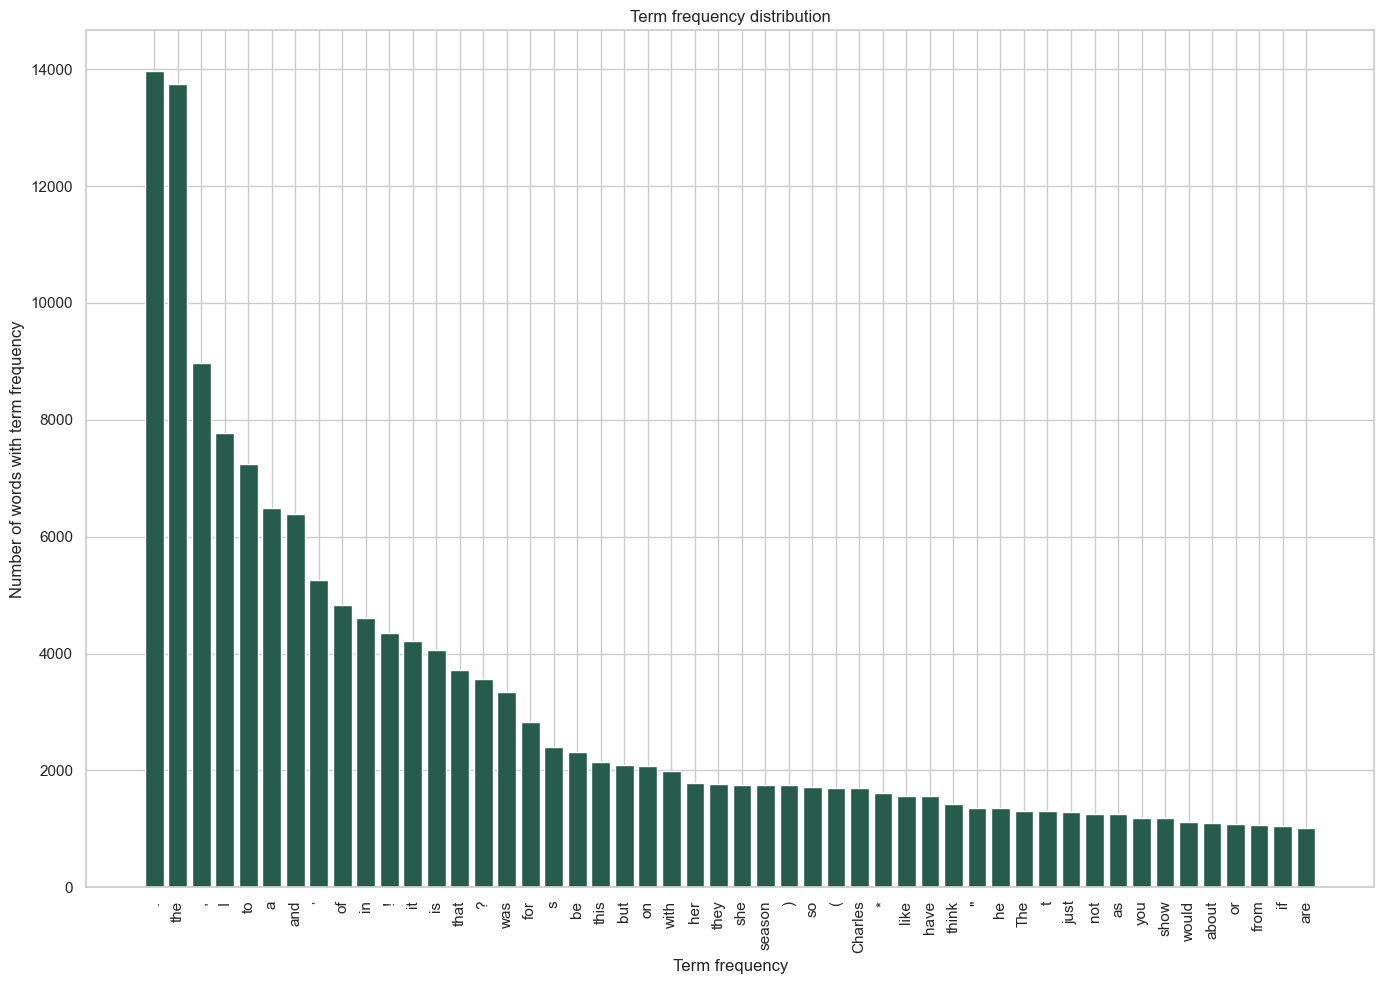

In [22]:
flatted_unprocessed_token_list = [element for innerList in unprocessed_token_lists for element in innerList]   

helper.compute_term_freq(flatted_unprocessed_token_list, True)

-----------------
Term frequency
-----------------

season: 2171
charles: 1717
like: 1648
think: 1434
show: 1188
would: 1145
one: 1014
sazz: 989
episode: 870
love: 869
also: 842
mabel: 791
know: 748
could: 735
see: 696
get: 674
really: 633
time: 621
im: 605
maybe: 594
oliver: 593
someone: 522
i'm: 501
something: 498
character: 492
apartment: 491
good: 478
much: 475
going: 459
killer: 453
people: 450
building: 444
martin: 444
murder: 443
first: 431
back: 418
way: 410
new: 407
even: 407
make: 386
dont: 384
want: 375
still: 372
got: 362
howard: 361
great: 357
thought: 351
well: 350
last: 345
jan: 341
----------------------------------


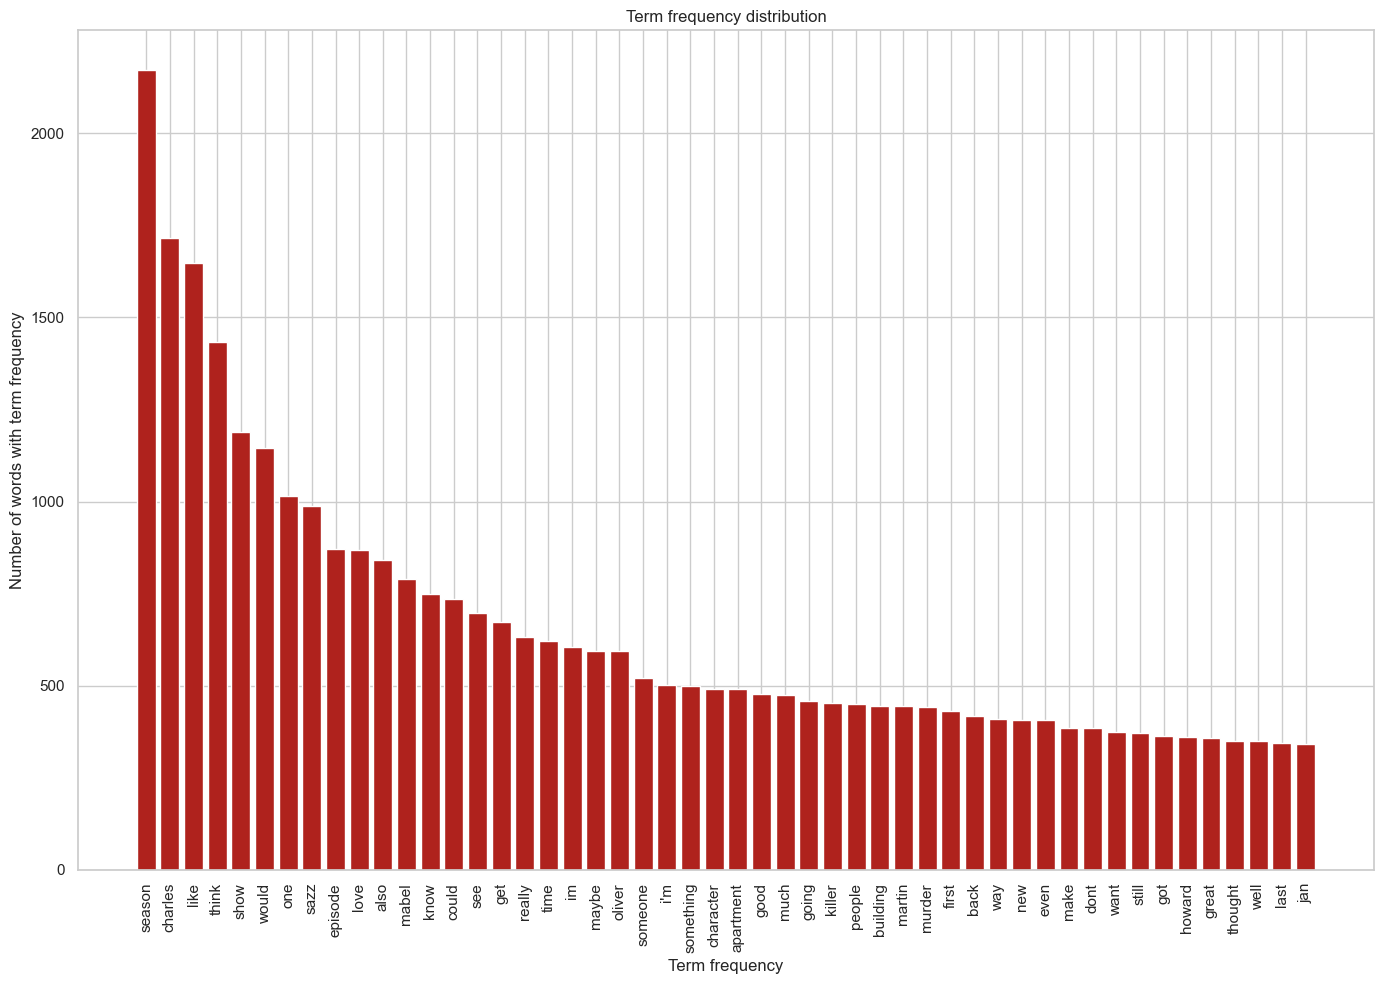

In [23]:
processed_token_lists = [element for innerList in processed_token_lists for element in innerList]   

helper.compute_term_freq(processed_token_lists, True, mabel)

In [24]:
print(f'Number of unprocessed tokens: {len(flatted_unprocessed_token_list)}\nNumber of processed tokens: {len(processed_token_lists)}')

Number of unprocessed tokens: 361594
Number of processed tokens: 157754


#### Step 3 : : Method
1. N-grams were explored to gain preliminary understanding of the sentiments in this subreddit
2. Sentiment analysis via N-grams, Count and Vader techniques 
3. Topic modelling via LDA topic model


In [25]:
top_50_bi_grams =  nltk.collocations.BigramCollocationFinder.from_words(processed_token_lists).ngram_fd.most_common(50)
top_50_tri_grams = nltk.collocations.TrigramCollocationFinder.from_words(processed_token_lists).ngram_fd.most_common(50)

In [26]:
# Sentiment analysis
count_sentiment_list = helper.sentiment_analysis('Count', omitb_df)



------------Analysing sentiment------------
Date: 2024-09-03 00:00:00

Post:
Season 4 - Episode 2: "Gates of Heaven" (Post Episode Discussion Thread) Welcome to r/OnlyMurdersHulu's official Only Murders in the Building Season 4 post episode discussion thread. 

Use this thread to discuss **Season 4: Episode 2: "Gates of Heaven"** **once you have finished watching the episode** which premiered September 3rd at 12:00 am EST.\*

If you are currently watching Episode 2, please be sure to check out the relevant Live Discussion Thread before commenting here, so you don't get spoiled.

A reminder that the sub will be locked for new posts for 24 hours following the episode's release. [More information here](https://www.reddit.com/r/OnlyMurdersHulu/comments/1ewm86s/only_murders_in_the_building_season_4_one_week_to/?utm_source=share&utm_medium=web3x&utm_name=web3xcss&utm_term=1&utm_content=share_button).

A reminder on spoilers:

* Keep spoilers out of any post titles
* Do not share spoilers f

In [27]:
vader_sentiment_list = helper.sentiment_analysis('Vader', omitb_df)



------------Analysing sentiment------------
Date: 2024-09-03 00:00:00

Post:
Season 4 - Episode 2: "Gates of Heaven" (Post Episode Discussion Thread) Welcome to r/OnlyMurdersHulu's official Only Murders in the Building Season 4 post episode discussion thread. 

Use this thread to discuss **Season 4: Episode 2: "Gates of Heaven"** **once you have finished watching the episode** which premiered September 3rd at 12:00 am EST.\*

If you are currently watching Episode 2, please be sure to check out the relevant Live Discussion Thread before commenting here, so you don't get spoiled.

A reminder that the sub will be locked for new posts for 24 hours following the episode's release. [More information here](https://www.reddit.com/r/OnlyMurdersHulu/comments/1ewm86s/only_murders_in_the_building_season_4_one_week_to/?utm_source=share&utm_medium=web3x&utm_name=web3xcss&utm_term=1&utm_content=share_button).

A reminder on spoilers:

* Keep spoilers out of any post titles
* Do not share spoilers f

In [28]:
# Topic modelling
num_topic = 10
max_word_count_to_display = 15
num_features = 1500

In [29]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words='english')
tf = tf_vectorizer.fit_transform(processed_token_lists)

tf_feature_names = tf_vectorizer.get_feature_names_out()

In [30]:
lda_model = LatentDirichletAllocation(n_components =num_topic, max_iter=10, learning_method='online').fit(tf)

#### Step 4 : : Analysis

In [31]:
# n-grams
top_50_bi_grams

[(('steve', 'martin'), 220),
 (('martin', 'short'), 157),
 (('feel', 'like'), 150),
 (('murders', 'building'), 146),
 (('gif', 'giphy'), 140),
 (('meryl', 'streep'), 105),
 (('last', 'season'), 99),
 (('pickwick', 'triplets'), 95),
 (('dont', 'think'), 89),
 (('looks', 'like'), 89),
 (('anyone', 'else'), 87),
 (('eugene', 'levy'), 84),
 (('selena', 'gomez'), 83),
 (('paul', 'rudd'), 74),
 (('scott', 'bakula'), 73),
 (('charles', 'oliver'), 72),
 (('red', 'herring'), 70),
 (('murder', 'mystery'), 69),
 (('upon', 'time'), 68),
 (('time', 'west'), 68),
 (('charles', 'apartment'), 67),
 (('season', 'one'), 65),
 (('dont', 'know'), 63),
 (('love', 'interest'), 63),
 (('seems', 'like'), 62),
 (('next', 'season'), 62),
 (('first', 'episode'), 61),
 (('love', 'show'), 61),
 (('west', 'tower'), 58),
 (('someone', 'else'), 58),
 (('season', 'episode'), 57),
 (('fly', 'wall'), 55),
 (('eva', 'longoria'), 54),
 (('oliver', 'putnam'), 54),
 (('felt', 'like'), 52),
 (('make', 'sense'), 52),
 (('make

In [32]:
top_50_tri_grams

[(('upon', 'time', 'west'), 68),
 (('steve', 'martin', 'martin'), 45),
 (('martin', 'martin', 'short'), 45),
 (('murders', 'building', 'season'), 35),
 (('death', 'rattle', 'dazzle'), 22),
 (('whole', 'new', 'direction'), 18),
 (('episodes', 'episode', '4.10'), 18),
 (('new', 'love', 'interest'), 16),
 (('would', 'make', 'sense'), 15),
 (('charles', 'oliver', 'mabel'), 15),
 (('first', 'two', 'seasons'), 15),
 (('true', 'crime', 'podcast'), 13),
 (('bakula', 'says', 'hi'), 13),
 (('investigation', 'whole', 'new'), 13),
 (('would', 'love', 'see'), 13),
 (('love', 'interest', 'season'), 13),
 (('id', 'love', 'see'), 12),
 (('charles', 'haden', 'savage'), 11),
 (('bullet', 'hole', 'window'), 10),
 (('interest', 'every', 'season'), 10),
 (('note', 'jans', 'door'), 9),
 (('anyone', 'else', 'notice'), 9),
 (('sends', 'investigation', 'whole'), 9),
 (("i'd", 'like', 'see'), 9),
 (('love', 'interest', 'every'), 9),
 (('stand', 'close', 'sting'), 9),
 (('olimabel', 'charles', 'silent'), 8),
 ((

Number of posts per date ordered:
          Date  count
252 2024-08-29     62
253 2024-08-30     39
254 2024-08-31     30
257 2024-09-03     30
251 2024-08-28     27


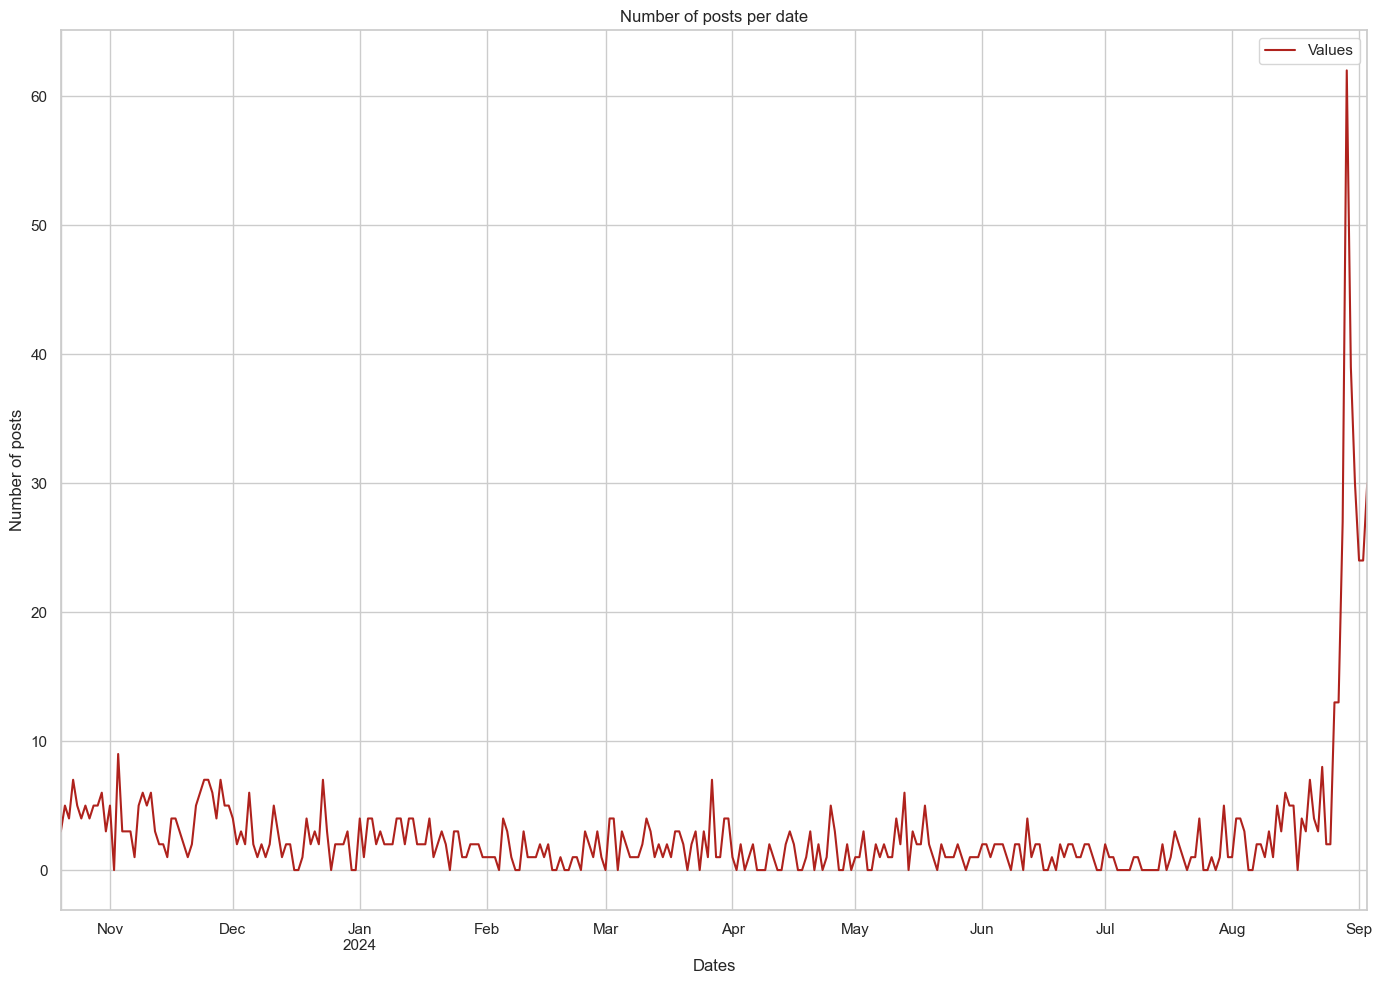

In [33]:
# Posts per date
num_posts_per_date = omitb_df.groupby('Date')['Post'].count()
visualiser.display_time_series_stats(num_posts_per_date, 'count', 'Number of posts per date', 'Dates', 'Number of posts', mabel)

Number of comments per date ordered:
          Date   sum
250 2024-08-27  1865
257 2024-09-03  1712
252 2024-08-29   860
251 2024-08-28   639
254 2024-08-31   583


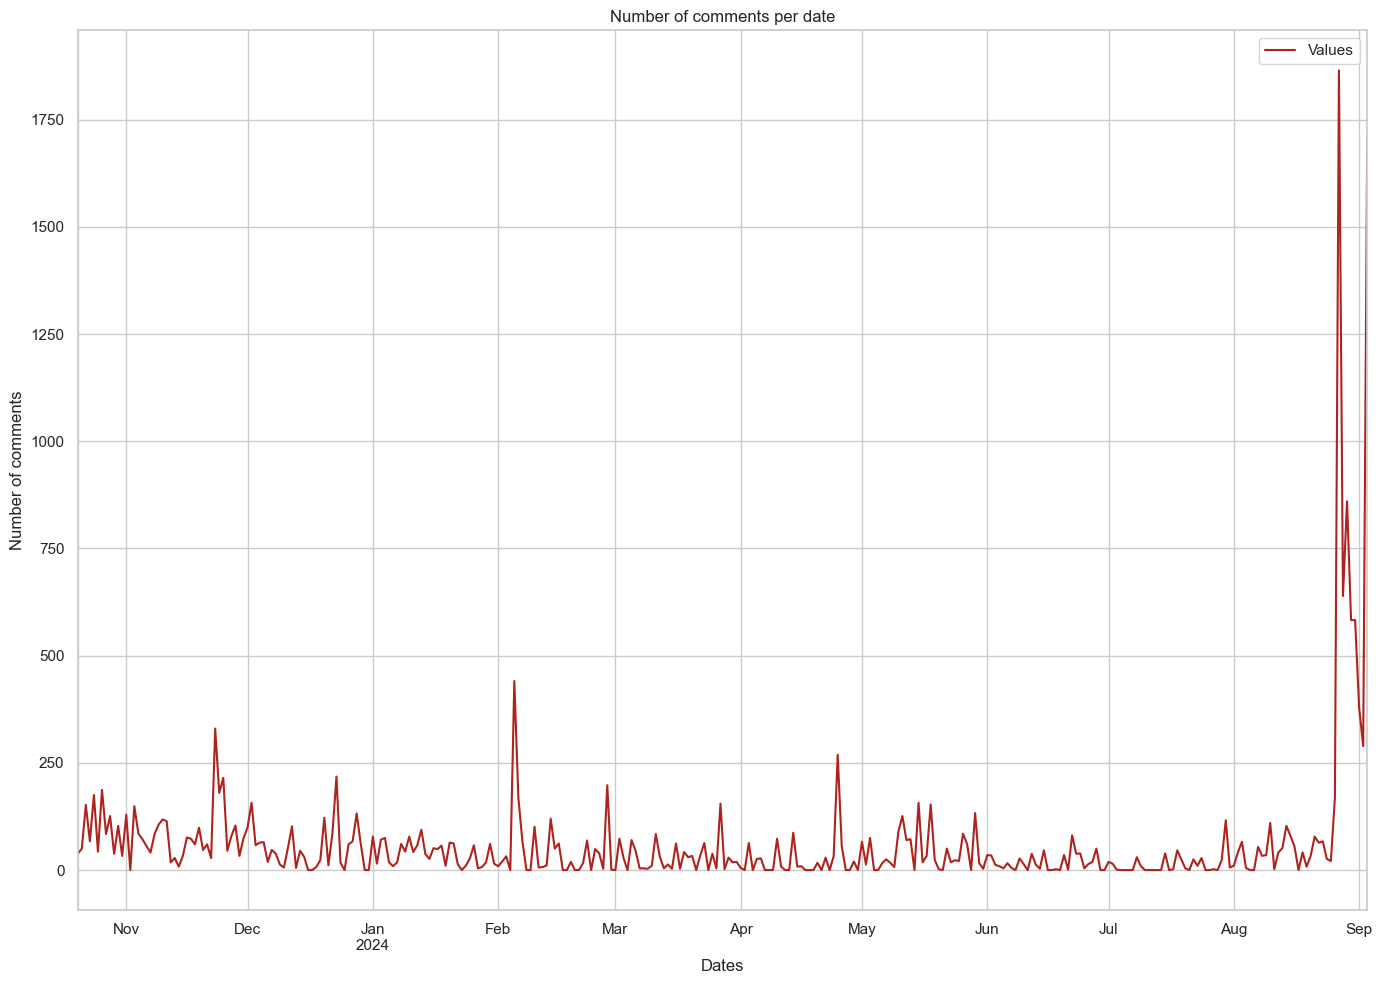

In [34]:
# Comments per date
num_comments_per_date = omitb_df.groupby('Date')['Num_comments'].sum()
visualiser.display_time_series_stats(num_comments_per_date, 'sum', 'Number of comments per date', 'Dates', 'Number of comments', mabel)

Posts per author:
           Author  count
412   kaitlinsmom     38
382   goawayjules     35
487  taydraisabot     20
200          None     19
386    hannahlemp     18


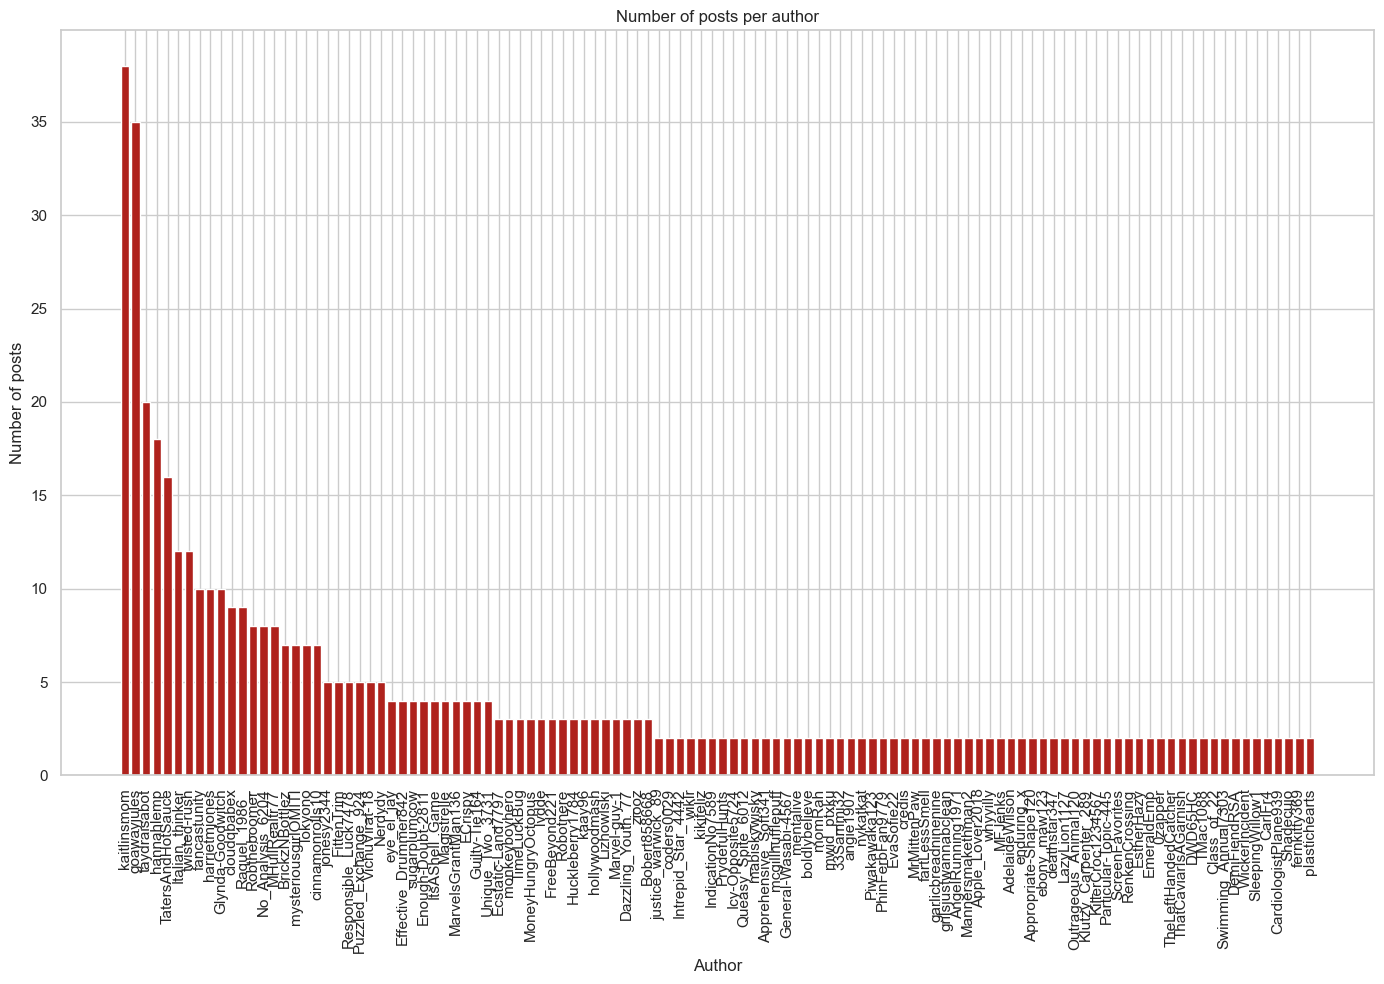

In [35]:
# Posts per author
num_posts_per_author = omitb_df.groupby('Author')['Post'].count()

num_posts_per_author_ordered = num_posts_per_author.reset_index(name='count').sort_values(['count'], ascending=False)
print(f'Posts per author:\n{num_posts_per_author_ordered.head()}')

filtered_df = num_posts_per_author_ordered[num_posts_per_author_ordered['count'] > 1 ]
filtered_df = filtered_df[filtered_df['Author'] != 'None']

num_posts_per_author_y = filtered_df['count']
author_x = filtered_df['Author']

visualiser.generate_bar_chart(author_x, num_posts_per_author_y, mabel, 'Number of posts per author', 'Author', 'Number of posts')

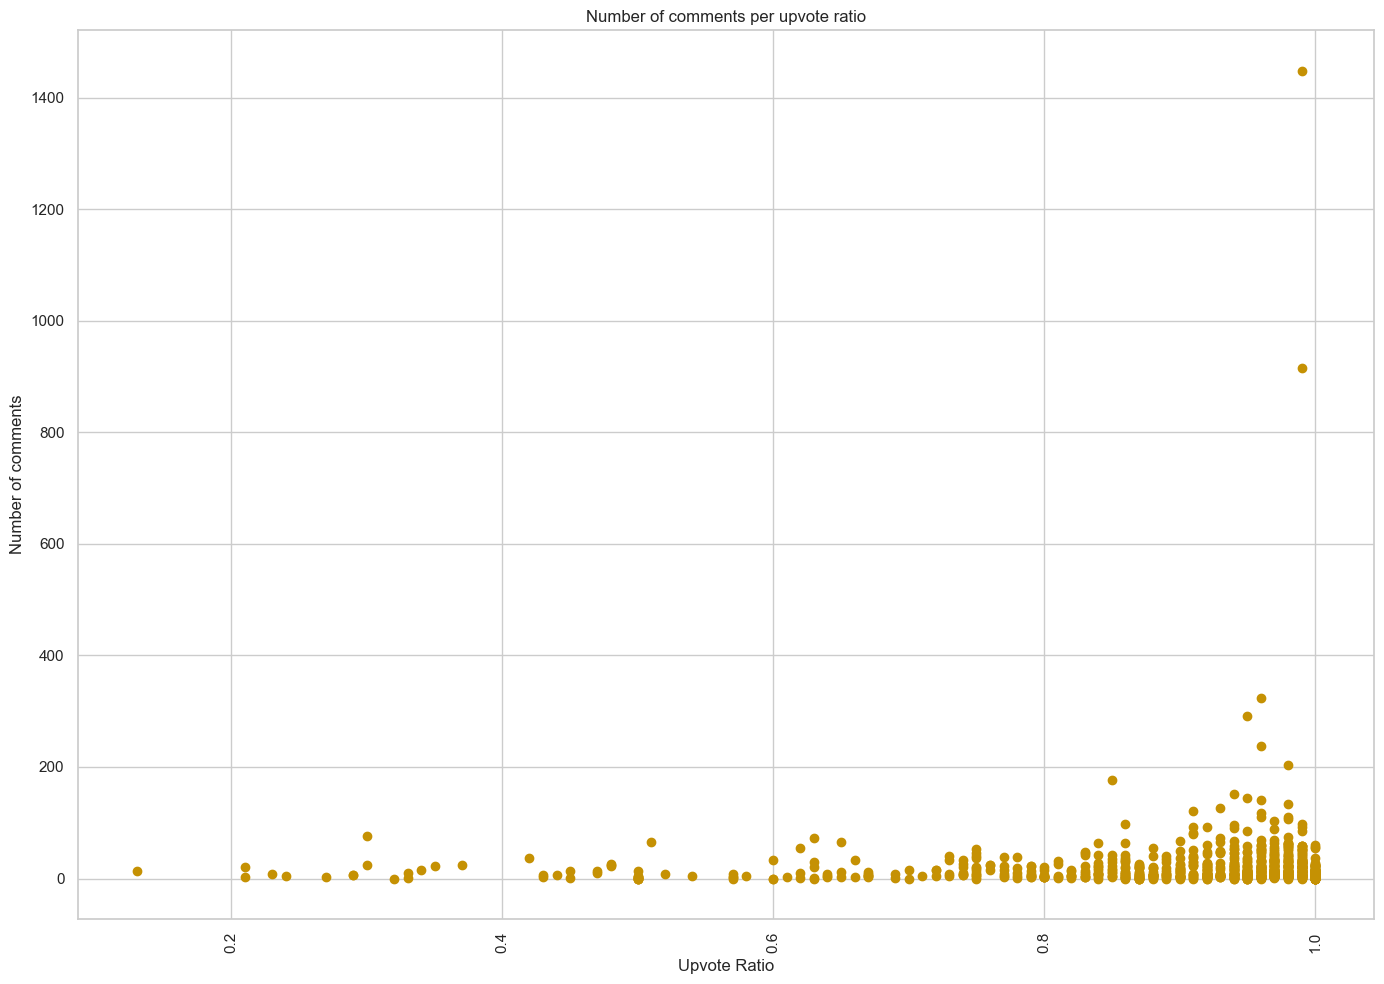

In [36]:
# Comments vs upvote_ratio 
num_comments_y = omitb_df['Num_comments'].tolist()
upvote_ratio_x = omitb_df['Upvote_ratio'].tolist()

visualiser.generate_scatter_plot(upvote_ratio_x, num_comments_y, charles, 'Number of comments per upvote ratio', 'Upvote Ratio', 'Number of comments')

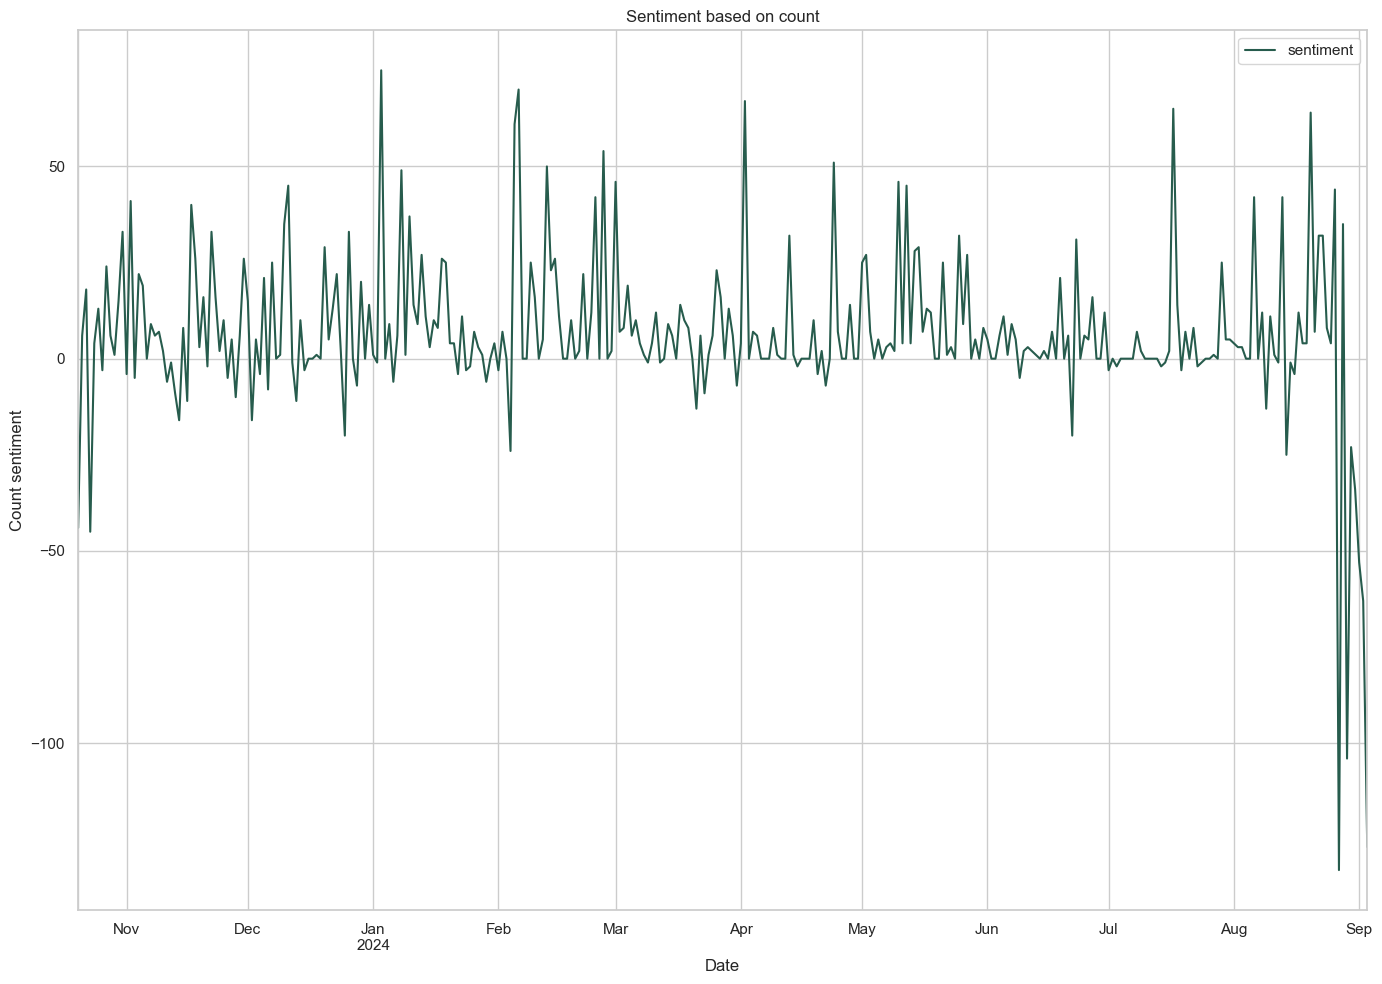

In [37]:
# Sentiment analysis
visualiser.generate_time_series(count_sentiment_list, 'Sentiment based on count', 'date', 'sentiment', 'Date', 'Count sentiment', oliver)

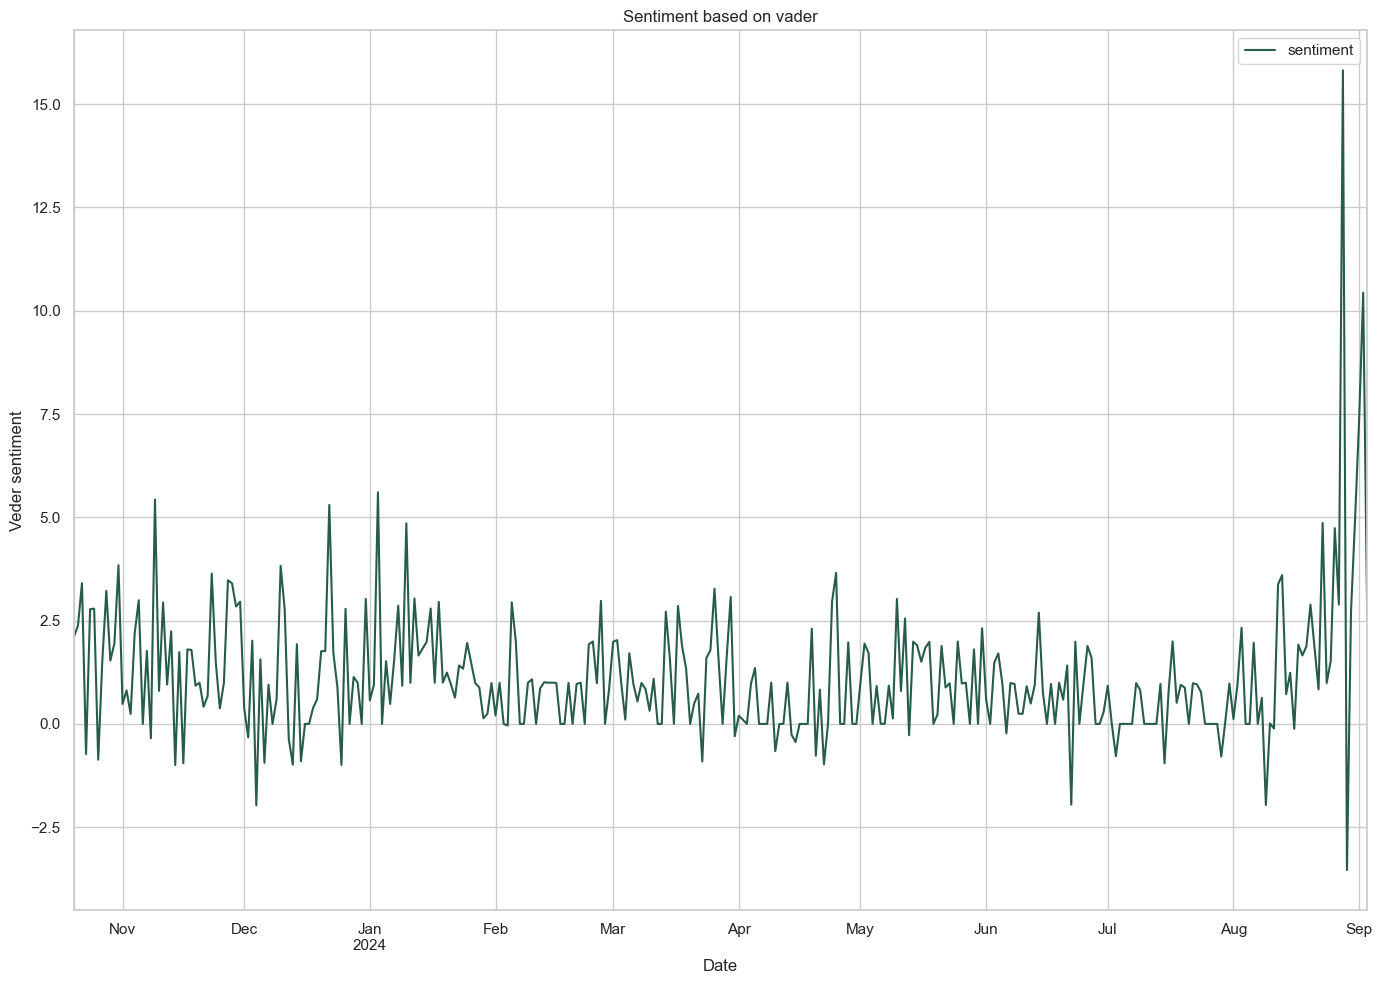

In [38]:
visualiser.generate_time_series(vader_sentiment_list, 'Sentiment based on vader', 'date', 'sentiment', 'Date', 'Veder sentiment', oliver)

In [39]:
visualiser.display_topics(lda_model, tf_feature_names, max_word_count_to_display)

Topic 0:
mabel sazz people thought jan didnt death story makes old seen triplets trying funny brazzos
Topic 1:
think really time great murders end trio said look life wanted set dead sense start
Topic 2:
character building dont got podcast howard lol watch hope episodes movie mystery right favorite definitely
Topic 3:
charles oliver killer want lot sure kind person watched felt joy amazing theres s4 seeing
Topic 4:
love going theo selena characters scene bunny cast song saw different streep far friend went
Topic 5:
episode apartment best seasons say things ve big better moriarty ll teddy started night head
Topic 6:
maybe murder way make shes series loretta yes oh real comedy long remember bad says
Topic 7:
like martin steve actually hes mean bit playing day years knew point oscar friends away
Topic 8:
know im good feel little arconia short thing need loved shows come getting ive pretty
Topic 9:
season new omitb probably fun ben la watching thats theory dips work gif looks giphy


In [40]:
# pyLDAvis
panel = pyLDAvis.lda_model.prepare(lda_model, tf, tf_vectorizer, mds='tsne')

pyLDAvis.display(panel)

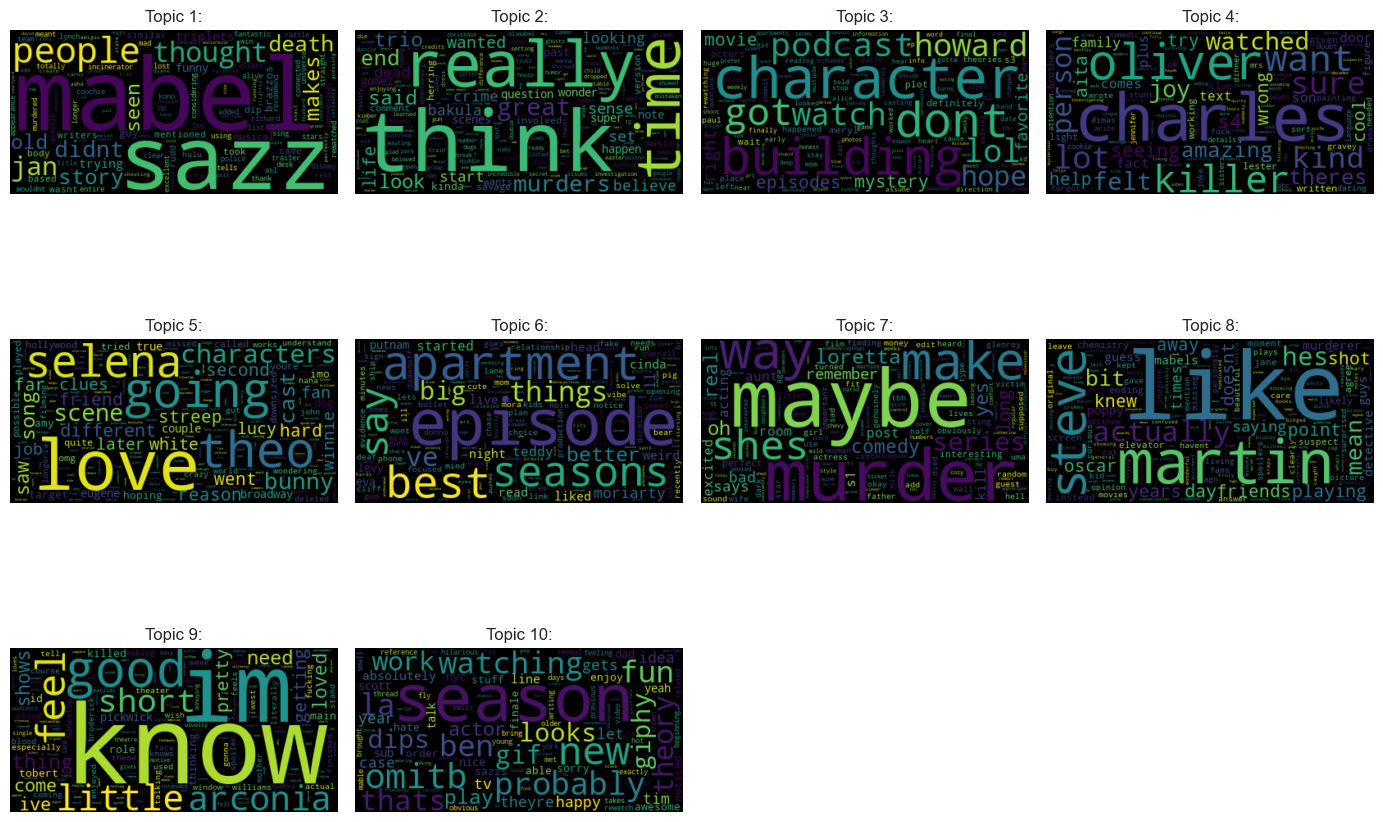

In [41]:
# wordcloud
visualiser.display_word_cloud(lda_model, tf_feature_names)